Customer Lifetime Value (CLTV) is a critical business metric that estimates the total revenue a company can expect to earn from a customer over the entire duration of their relationship. Rather than focusing solely on short-term transactions, CLTV emphasizes long-term profitability and customer retention.

In today's data-driven landscape, understanding CLTV allows businesses to make more informed decisions about marketing budgets, customer segmentation, and overall customer relationship strategies. High CLTV customers can be targeted with loyalty and upsell initiatives, while low CLTV segments might benefit from cost-efficient retention strategies or be deprioritized in resource allocation.

In this project, we aim to predict the CLTV of customers using historical transactional data. By analyzing features such as purchase frequency, monetary value, and recency of purchases, we train a machine learning model to estimate future customer value. This prediction enables more personalized marketing efforts, efficient resource allocation, and ultimately, improved profitability.

In [1]:
#import modules
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime as dt
import numpy as np


In [2]:
df = pd.read_excel(r"C:\Users\SD\Downloads\online+retail\Online Retail.xlsx")


In [3]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
filtered_data=df[['Country','CustomerID']].drop_duplicates()


<Axes: xlabel='Country'>

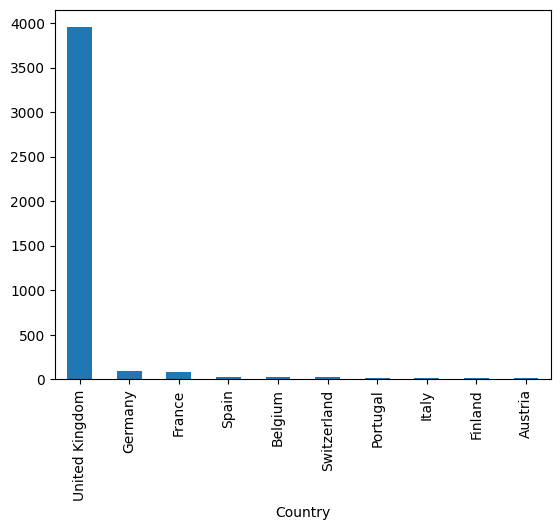

In [5]:
#Top ten country's customer
filtered_data.Country.value_counts()[:10].plot(kind='bar')


We can see that most customers are from the United Kingdom, so we will be running our analysis based on the customers from the United Kingdom

In [6]:
## Filtering data for only United Kingdom

uk_data=df[df.Country=='United Kingdom']
uk_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 495478 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    495478 non-null  object        
 1   StockCode    495478 non-null  object        
 2   Description  494024 non-null  object        
 3   Quantity     495478 non-null  int64         
 4   InvoiceDate  495478 non-null  datetime64[ns]
 5   UnitPrice    495478 non-null  float64       
 6   CustomerID   361878 non-null  float64       
 7   Country      495478 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 34.0+ MB


In [7]:
## Summary Statistics

uk_data.describe()


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,495478.000000,495478,495478.000000,361878.000000
mean,8.605486,2011-07-04 05:01:41.098131456,4.532422,15547.871368
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-27 12:06:00,1.250000,14194.000000
50%,3.000000,2011-07-19 11:47:00,2.100000,15514.000000
75%,10.000000,2011-10-20 10:41:00,4.130000,16931.000000
max,80995.000000,2011-12-09 12:49:00,38970.000000,18287.000000
std,227.588756,NaN,99.315438,1594.402590


Some of the customers have ordered in a negative quantity, which is not possible. So, I will need to filter Quantity greater than zero.

In [8]:
uk_data = uk_data.query('Quantity > 0')

uk_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 486286 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    486286 non-null  object        
 1   StockCode    486286 non-null  object        
 2   Description  485694 non-null  object        
 3   Quantity     486286 non-null  int64         
 4   InvoiceDate  486286 non-null  datetime64[ns]
 5   UnitPrice    486286 non-null  float64       
 6   CustomerID   354345 non-null  float64       
 7   Country      486286 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.4+ MB


In [9]:
uk_data.describe()


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,486286.000000,486286,486286.000000,354345.000000
mean,9.734640,2011-07-04 10:23:18.567221760,3.794976,15552.436219
min,1.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-27 12:21:00,1.250000,14194.000000
50%,3.000000,2011-07-19 14:29:00,2.100000,15522.000000
75%,10.000000,2011-10-20 12:43:00,4.130000,16931.000000
max,80995.000000,2011-12-09 12:49:00,13541.330000,18287.000000
std,163.262428,NaN,41.271159,1594.546025


In [10]:
## Selecting necessary columns for the analysis

uk_data=uk_data[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]


In [11]:
uk_data.head(2)

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55
1,17850.0,2010-12-01 08:26:00,536365,6,3.39


In [12]:
## Calculating Total Sales

uk_data['TotalSales'] = uk_data['Quantity'] * uk_data['UnitPrice']


In [13]:
uk_data.head(1)

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalSales
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.3


In [14]:
## Calculating Recency, Frequency and Monetary value (RFM)


uk_RFM=uk_data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (date.max() - date.min()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'Quantity': lambda quant: quant.sum(),
                                        'TotalSales': lambda price: price.sum()})


In [15]:
uk_RFM.head(5)

,InvoiceDate,InvoiceNo,Quantity,TotalSales
CustomerID,,,,
12346.0,0,1,74215,77183.60
12747.0,366,103,1275,4196.01
12748.0,372,4596,25748,33719.73
12749.0,209,199,1471,4090.88
12820.0,323,59,722,942.34


In [16]:
## Renaming the columns

uk_RFM.columns=['num_days','num_transactions','num_units','spent_money']
uk_RFM.head()


,num_days,num_transactions,num_units,spent_money
CustomerID,,,,
12346.0,0,1,74215,77183.60
12747.0,366,103,1275,4196.01
12748.0,372,4596,25748,33719.73
12749.0,209,199,1471,4090.88
12820.0,323,59,722,942.34


### Calculating CLV

 CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.

 Customer Value = Average Order Value * Purchase Frequency


##### Calculate Average Order Value

In [17]:
# Average Order Value


uk_RFM['avg_order_value']=uk_RFM['spent_money']/uk_RFM['num_transactions']


In [18]:
uk_RFM.head(1)

,num_days,num_transactions,num_units,spent_money,avg_order_value
CustomerID,,,,,
12346.0,0,1,74215,77183.6,77183.6


##### Calculate Purchase Frequency

In [19]:
## Purchase Frequency

purchase_frequency=sum(uk_RFM['num_transactions'])/uk_RFM.shape[0]


##### Calculate Repeat Rate and Churn Rate

In [20]:
# Repeat Rate
repeat_rate=uk_RFM[uk_RFM.num_transactions > 1].shape[0]/uk_RFM.shape[0]


In [21]:
#Churn Rate
churn_rate=1-repeat_rate


In [22]:
purchase_frequency,repeat_rate,churn_rate


(90.37107880642694, 0.9818923743942872, 0.018107625605712774)

##### Calculate Profit Margin

Let's assume our business has approx 5% profit on the total sale.

In [23]:
# Profit Margin
uk_RFM['profit_margin']=uk_RFM['spent_money']*0.05


In [24]:
uk_RFM.head(1)

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin
CustomerID,,,,,,
12346.0,0,1,74215,77183.6,77183.6,3859.18


##### Calculate Customer Lifetime Value

In [25]:
# Customer Value

uk_RFM['CLV']=(uk_RFM['avg_order_value']*purchase_frequency)/churn_rate


In [26]:
#Customer Lifetime Value
uk_RFM['cust_lifetime_value']=uk_RFM['CLV']*uk_RFM['profit_margin']


In [28]:
uk_RFM.head(4)

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,CLV,cust_lifetime_value
CustomerID,,,,,,,,
12346.0,0,1,74215,77183.60,77183.600000,3859.1800,3.852060e+08,1.486579e+12
12747.0,366,103,1275,4196.01,40.737961,209.8005,2.033140e+05,4.265538e+07
12748.0,372,4596,25748,33719.73,7.336756,1685.9865,3.661610e+04,6.173424e+07
12749.0,209,199,1471,4090.88,20.557186,204.5440,1.025963e+05,2.098545e+07


### Prediction Model for CLTV

In [29]:
uk_data.head()


,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalSales
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


In [30]:
## Extract Month and Year from Invoice Date

uk_data['month_yr'] = uk_data['InvoiceDate'].apply(lambda x: x.strftime('%b-%Y'))


In [31]:
uk_data.head(1)


,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalSales,month_yr
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.3,Dec-2010


In [34]:
## Using a pivot table to summarize the display the sales by customer for every Month-year

sale=uk_data.pivot_table(index=['CustomerID'],columns=['month_yr'],values='TotalSales',aggfunc='sum',fill_value=0).reset_index()


In [35]:
sale.head()


month_yr,CustomerID,Apr-2011,Aug-2011,Dec-2010,Dec-2011,Feb-2011,Jan-2011,Jul-2011,Jun-2011,Mar-2011,May-2011,Nov-2011,Oct-2011,Sep-2011
0,12346.0,0.00,0.00,0.00,0.00,0.00,77183.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,12747.0,0.00,301.70,706.27,438.50,0.00,303.04,0.00,376.30,310.78,771.31,312.73,675.38,0.00
2,12748.0,1100.37,898.24,4228.13,1070.27,389.64,418.77,1113.27,2006.26,1179.37,2234.50,10639.23,2292.84,6148.84
3,12749.0,0.00,1896.13,0.00,763.06,0.00,0.00,0.00,0.00,0.00,859.10,572.59,0.00,0.00
4,12820.0,0.00,0.00,0.00,210.35,0.00,170.46,0.00,0.00,0.00,0.00,0.00,343.76,217.77


In [36]:
### Sum all the month sales

sale['CLV']=sale.iloc[:,2:].sum(axis=1)


In [37]:
sale.head()


month_yr,CustomerID,Apr-2011,Aug-2011,Dec-2010,Dec-2011,Feb-2011,Jan-2011,Jul-2011,Jun-2011,Mar-2011,May-2011,Nov-2011,Oct-2011,Sep-2011,CLV
0,12346.0,0.00,0.00,0.00,0.00,0.00,77183.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,77183.60
1,12747.0,0.00,301.70,706.27,438.50,0.00,303.04,0.00,376.30,310.78,771.31,312.73,675.38,0.00,4196.01
2,12748.0,1100.37,898.24,4228.13,1070.27,389.64,418.77,1113.27,2006.26,1179.37,2234.50,10639.23,2292.84,6148.84,32619.36
3,12749.0,0.00,1896.13,0.00,763.06,0.00,0.00,0.00,0.00,0.00,859.10,572.59,0.00,0.00,4090.88
4,12820.0,0.00,0.00,0.00,210.35,0.00,170.46,0.00,0.00,0.00,0.00,0.00,343.76,217.77,942.34


### Feature Selection

In [38]:
## Selecting the latest 6 months for the independent variable

X=sale[['Dec-2011','Nov-2011', 'Oct-2011','Sep-2011','Aug-2011','Jul-2011']]
y=sale[['CLV']]


### Splitting Data


In [41]:
#split training set and test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


##### Model Development

In [42]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)


In [43]:
# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)


[213.12183157]
[[1.00029613 0.83144479 1.66645962 1.50036263 1.48285267 2.97588777]]


#### Model Evaluation

In [44]:
from sklearn import metrics

# compute the R Square for model
print("R-Square:",metrics.r2_score(y_test, y_pred))


R-Square: 0.9306400957145082


In [47]:
# calculate MAE 
print("MAE:",metrics.mean_absolute_error(y_test,y_pred))

#calculate mean squared error
print("MSE",metrics.mean_squared_error(y_test, y_pred))
# compute the RMSE of our predictions
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


MAE: 586.6002095245339
MSE 2165328.800375159
RMSE: 1471.5056236301507


In [48]:
results = X_test.copy()
results['Actual_CLTV'] = y_test
results['Predicted_CLTV'] = y_pred
results.head()


month_yr,Dec-2011,Nov-2011,Oct-2011,Sep-2011,Aug-2011,Jul-2011,Actual_CLTV,Predicted_CLTV
538,0.0,0.00,0.00,0.00,0.0,0.0,0.00,213.121832
3000,0.0,415.18,0.00,0.00,340.9,0.0,1126.02,1063.825555
825,0.0,462.44,500.21,1261.81,0.0,0.0,4147.96,3324.367495
924,62.5,643.63,0.00,0.00,0.0,0.0,706.13,810.783152
3093,0.0,0.00,0.00,0.00,0.0,0.0,157.09,213.121832


In [49]:
results['CLTV_Segment'] = pd.qcut(results['Predicted_CLTV'], q=4, labels=['Low', 'Mid', 'High', 'Very High'])


In [51]:
results.head()


month_yr,Dec-2011,Nov-2011,Oct-2011,Sep-2011,Aug-2011,Jul-2011,Actual_CLTV,Predicted_CLTV,CLTV_Segment
538,0.0,0.00,0.00,0.00,0.0,0.0,0.00,213.121832,Low
3000,0.0,415.18,0.00,0.00,340.9,0.0,1126.02,1063.825555,High
825,0.0,462.44,500.21,1261.81,0.0,0.0,4147.96,3324.367495,Very High
924,62.5,643.63,0.00,0.00,0.0,0.0,706.13,810.783152,High
3093,0.0,0.00,0.00,0.00,0.0,0.0,157.09,213.121832,Low
